SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #3: Holt, Winters, Theil-Wage models. Exponential Smoothing Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**  exponential smoothing models, Holt model,Winters model, Theil-Wage Model

**Your fitback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [28]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import math
import pandas.tseries.offsets as ofs

from utils import qualityMAPE, SimpleExponentialSmoothing
# from utils import plot_ts_forecast, plot_ts_forecast # don't forget to upload file in colab working repository
# import warnings as w
# from matplotlib import gridspec
# import plotly.plotly as py
# import seaborn as sns

from IPython.display import Image

%matplotlib inline

In [37]:
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
    
  FRC_TS = dict()

  for p in params_array:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)
     
#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
      FRC_TS['%s %s' % (alg_title, p)] = frc_ts
  
  return FRC_TS

def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
  frc_ts.columns = ts.columns+'; '+alg_title
  ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
  ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
  plt.xlabel("Time ticks")
  plt.ylabel("TS values")
  plt.legend()
  return ax

# Holt model, Winters Model, Theil-Wage Model

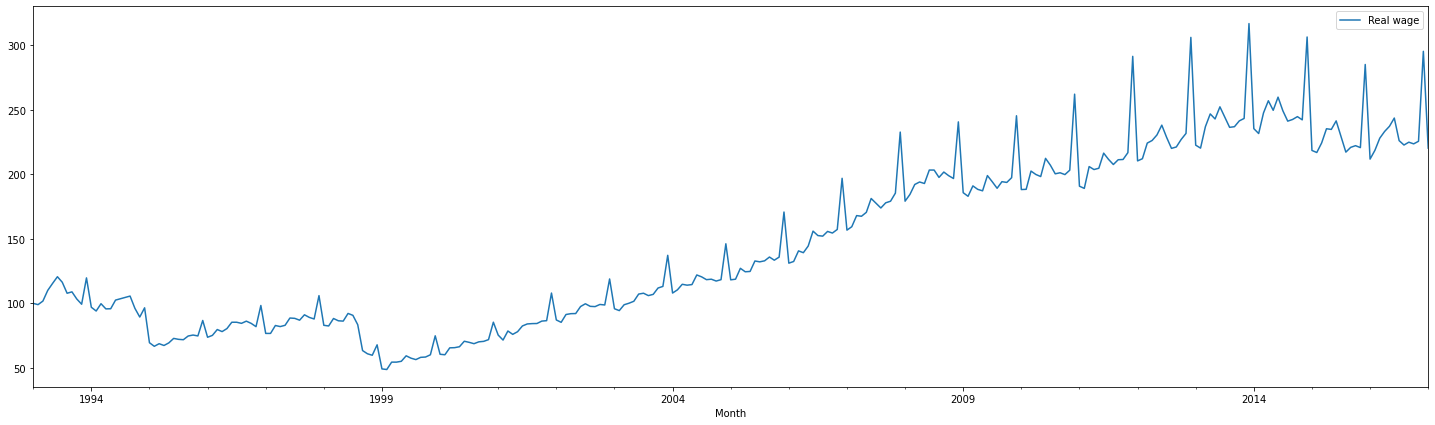

In [ ]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot(figsize=(25,7))

**Question:**
   * Which hidden components of the ts are not considered by SES?

## Holt Model

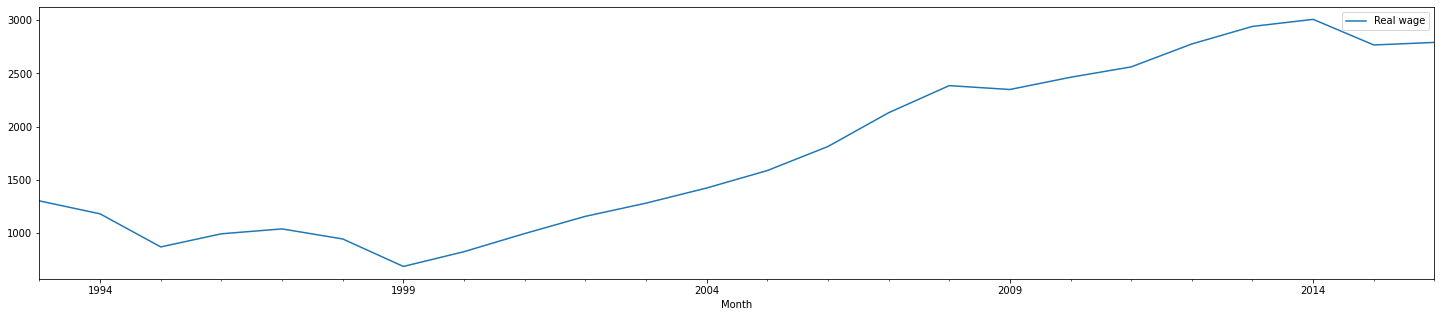

In [ ]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year.plot(figsize=(25,5))

In [39]:
alg_name

"SES {'alpha': 1.0, 'AdaptationPeriod': 10}"

MAPE: Real wage    0.088797
dtype: float64


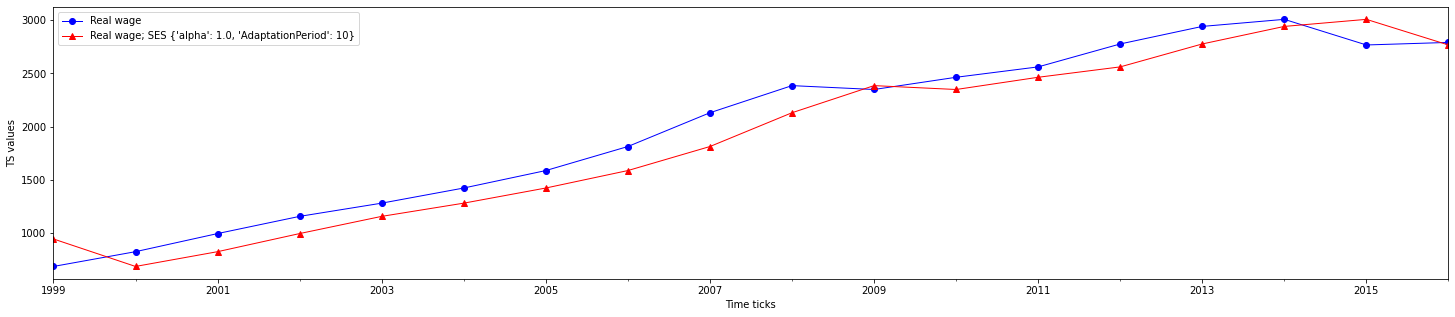

In [43]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
ESparams_array = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, alg_name =  'SimpleExponentialSmoothing', alg_title='SES'
                              ,params_array = ESparams_array, step='12MS')

# forecast accuracy 
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

# Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=alg_name)

test_period_start = '2000-01-01'
test_period_end = '2016-01-01'
print('MAPE: %s' % qualityMAPE(wage_year.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])


**Question:**
   * How to include trend component in Exponential Smoothing model?

**From Simple Exponential Smoothing to Holt Model**
$\varepsilon_t~-$ error component (unobserved noise)

$l_t$ $-$ changing slowly level of time series,

$\hat l_t~-$ an estimation of level

$\hat y_t~-$ forecast value for $y_t$ (made with delay = 1) 

${e_t = y_t - \hat y_t }$

<table border="0">
 <tr>
    <td><b style="font-size:30px">$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$Simple Exponential Smoothing$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
</b></td>
    <td><b style="font-size:30px">$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ Holt model (additive linear trend)$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$</b></td>
 </tr>
 <tr>
    <td>

Time Series Model    
    $$y_{t} = l_t + \color{red}{\varepsilon_t},$$

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$


$$\hat{l}_{t} = \alpha\cdot y_t+ (1-\alpha)\cdot \hat{y}_t = \hat y_t + \alpha \cdot \color{red}{e_t}$$
    <td>

Time series model:
$$  y_{t} = l_t + \color{red}{b_t} d + {\varepsilon_t} $$

Forecasting formula:
    $$  \hat y_{t+d} = l_t + \color{red}{b_t} d $$
    <!-- where $l_t$, $\color{red}{b_t}$ --- estimations of unopbserved components of level and trend correspondently -->


$$        l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1} ) = \color{red}{\hat y_{t} + \alpha e_t}$$ 

$$b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \color{red}{b_{t-1}+ \alpha\beta e_t}.$$</td>
 </tr>
</table>



<!-- Доказательство 

$$\beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = b_{t-1}+ \beta(l_t-l_{t-1}-b_{t-1})= b_{t-1}+ \beta(l_t-l_{t-1}-b_{t-1}) +\alpha e_t$$ -->



In [32]:
###################### Holt Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    beta <scalar in [0,1]> - linear trend smoothing parameter
#    
def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (l - l_prev) + (1- beta)*b
                
        FORECAST[t+h] = l+ b*h
    return FORECAST

MAPE: Real wage    0.071716
dtype: float64


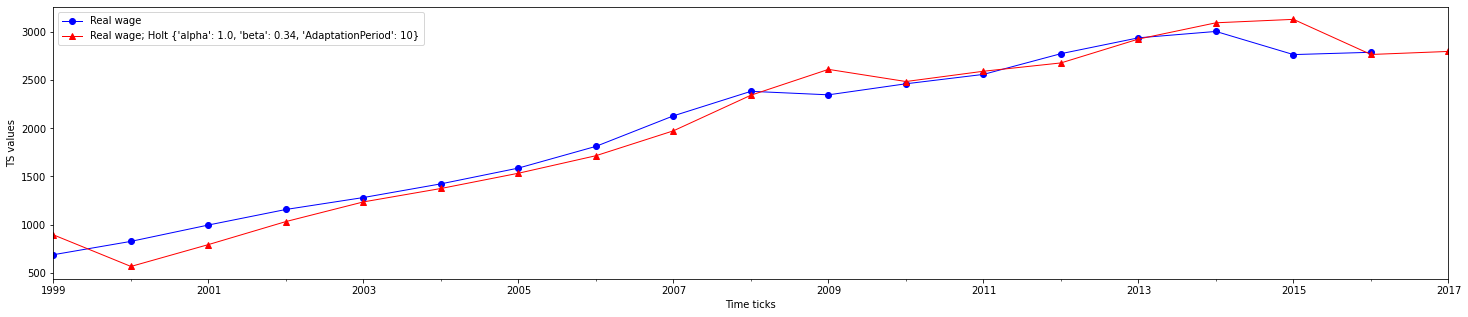

In [44]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
BETA = np.linspace(0.01,1,10)

holt_params_array = [{'alpha':alpha, 'beta':beta, 'AdaptationPeriod':10} for alpha in ALPHA for beta in BETA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, alg_name =  'HoltExponentialSmoothing', alg_title='Holt'
                              ,params_array = holt_params_array, step='12MS')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

# # Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_year.loc['1999-01-01':'2018-01-01'], FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=0, alg_title=alg_name)

print('MAPE: %s' % qualityMAPE(wage_year.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])

## Winters Model

In [46]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/seasonal_ts.csv', parse_dates=['Dates'], sep=';', dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2006-01-01,0,49,64,70.468,0,45.182,71,21.664,138,0
2006-01-02,0,56,60,57.368,0,39.506,27,19.664,76,6
2006-01-03,0,61,71,34.350,0,28.064,10,10.402,152,12
2006-01-04,0,32,59,40.186,0,40.256,27,9.938,67,12
2006-01-05,0,45,61,28.914,0,35.784,27,16.672,49,24


In [47]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2007-01-01,156,135,64,95.925,68,57.934,30,28.854,19,0
2007-01-02,138,117,62,43.775,63,52.693,19,24.478,14,18
2007-01-03,148,98,67,50.750,57,43.406,15,15.704,18,6
2007-01-04,147,86,67,54.020,47,53.018,9,21.846,15,6
2007-01-05,146,124,71,50.400,59,74.212,15,33.082,2,12


**Questions** 
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

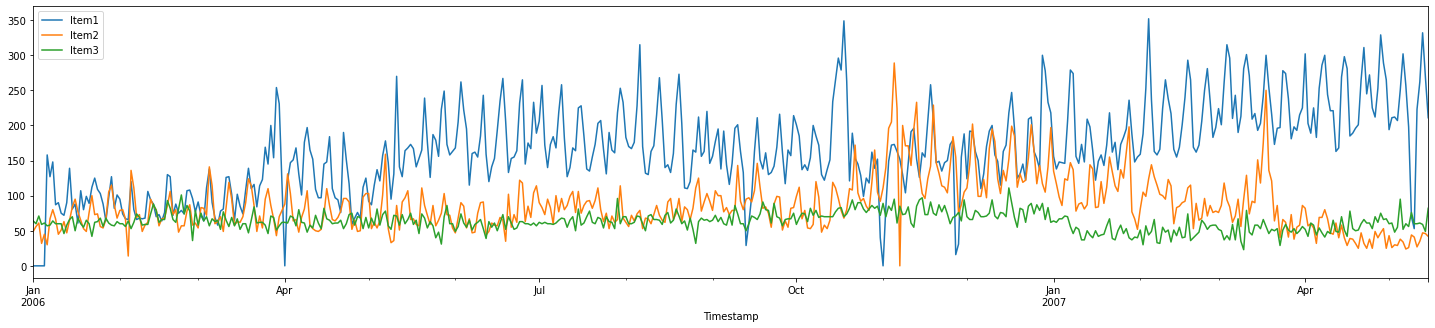

In [48]:
# fig = plt.figure()
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot(figsize=(25,5))
# to save the pictures
# plt.savefig('../Lecture_TS_Forecasting/pic/TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions**

 - What are key aspects of these retail ts?
 - How to change SES model to consider seasonlaity in original data?

**Additive Winters Model = Additive Seasonality**

Time Series model
$$y_t = l_t + s_{t}+\varepsilon_t$$
where $s_t$ - is a seasonla component of period $p$

Forecasting Model
$$\hat{y}_{t+d} = l_t +  s_{t-p+d }; \\
		l_{t}       	=  \alpha \left(y_t - s_{t-p}\right)+ \left(1-\alpha\right) \left(l_{t-1}\right)=\color{red}{l_{t-1} + \alpha e_t}; \\
		s_t         	= \gamma\left(y_t-l_{t-1}\right) + \left(1-\gamma\right)s_{t-p} = \color{red}{s_{t-p} + \gamma(1-\alpha)e_t}.
		$$

In [ ]:

###################### Additive Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - level smoothing parameter
#    gamma <scalar in [0,1]> - seasonality smoothing parameter

def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
            
        FORECAST[cntr+h] = l + s[cntr-p+1]
    return FORECAST


## Theil-Wage Model

**Questions** 
  - How to consider both additive trend and additive seasonality?

Time Series Model:
$$ \hat y_{t+d} = (l_t + b_t d) + s_{t}. $$
$s_t$ - seasonal component of period $p$,

Forecasting Model
$$ l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} )=\color{red}{l_{t-1} + b_{t-1} + \alpha e_t};$$

$$b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \color{red}{b_{t-1} + \alpha\beta e_t};$$
$$ s_t =\gamma (y_t-l_t) + (1-\gamma) s_{t-p} = \color{red}{s_{t-p} + \gamma(1-\alpha)e_t}.$$

In [ ]:

###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - level smoothing parameter
#    beta <scalar in [0,1]> - trend smoothing parameter
#    gamma <scalar in [0,1]> - seasonality smoothing parameter

def TWExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr-p+1]
    return FORECAST

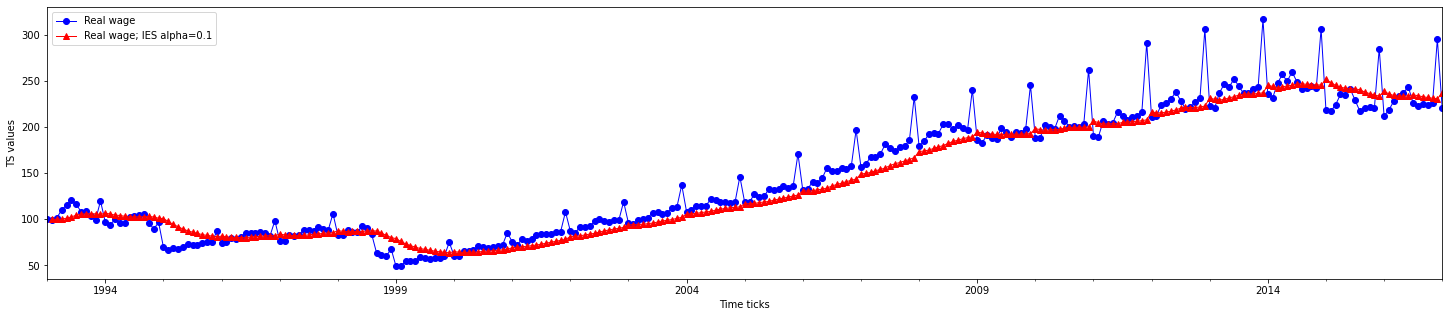

In [ ]:
ESparams_array = [{'alpha':0.1, 'AdaptationPeriod':10}]
FRC_WAGE = build_forecast(h=1, ts=wage, alg_name =  'SimpleExponentialSmoothing', alg_title='SES' ,params_array = ESparams_array)

plot_ts_forecast(wage.loc['1993-01-01':'2017-01-01'], FRC_WAGE[list(FRC_WAGE)[0]].loc['1993-01-01':'2017-01-01']
               , ts_num=0, alg_title='IES alpha=0.1')

**Question**
  * What indicates that forecast is inadequate (=there could be more proper forecastl)?

Search for the optimal $\alpha$ 

In [ ]:
ALPHA = np.linspace(0.01,0.99,99)
ESparams_array = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = build_forecast(h=1, ts=wage, alg_name =  'SimpleExponentialSmoothing', alg_title='SES' ,params_array = ESparams_array)

In [ ]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09-01':'2018-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()

SES {'alpha': 0.38, 'AdaptationPeriod': 10}                   0.058839
SES {'alpha': 0.37, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.39, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.4, 'AdaptationPeriod': 10}                    0.058872
SES {'alpha': 0.36000000000000004, 'AdaptationPeriod': 10}    0.058888
                                                                ...   
SES {'alpha': 0.05, 'AdaptationPeriod': 10}                   0.129426
SES {'alpha': 0.04, 'AdaptationPeriod': 10}                   0.147997
SES {'alpha': 0.03, 'AdaptationPeriod': 10}                   0.175454
SES {'alpha': 0.02, 'AdaptationPeriod': 10}                   0.219394
SES {'alpha': 0.01, 'AdaptationPeriod': 10}                   0.298435
Length: 99, dtype: float64

draw the forecast with optimial value $\alpha $

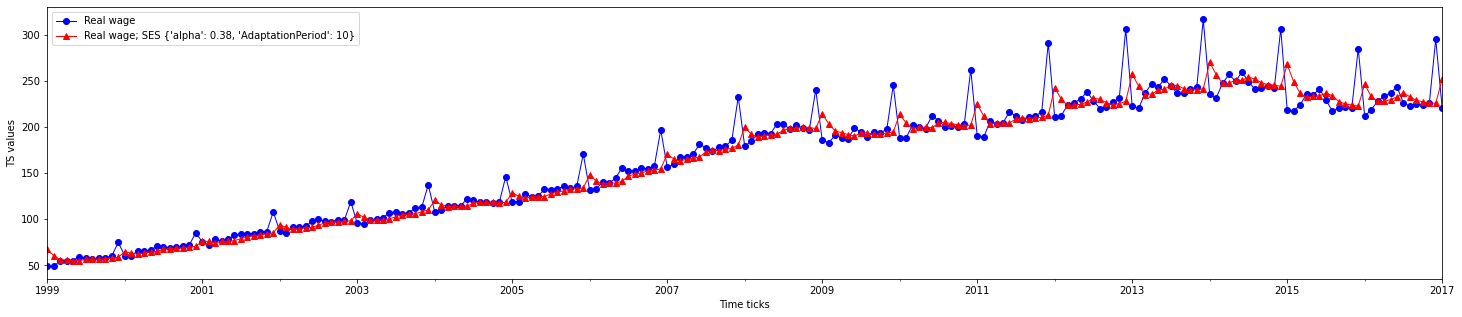

In [ ]:
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage.loc['1999-01-01':'2017-01-01'], FRC_WAGE[alg_name].loc['1999-01-01':'2017-01-01']
               , ts_num=0, alg_title=alg_name)

**Question**
    * Is forecast still inadequate?

Calculate loss of the forecast of TS in [02.2016, 01.2017]

In [ ]:
qualityMAPE(wage.loc['2016-02-01':'2017-01-01'], FRC_WAGE[alg_name].loc['2016-02-01':'2017-01-01'])[0]

Real wage    0.056378
dtype: float64

SES to Yearly Wage Data

In [ ]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year[-4:]

,Real wage
Month,
2013-01-01,2940.9
2014-01-01,3007.2
2015-01-01,2766.7
2016-01-01,2790.6


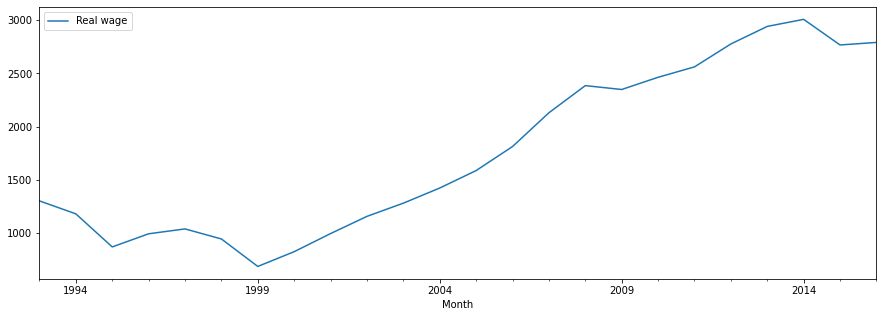

In [ ]:
wage_year.plot(figsize=(15,5))

Search of optimal $\alpha$ for aggregated data

Forecast with optimial value  $\alpha$

MAPE: Real wage    0.047746
dtype: float64


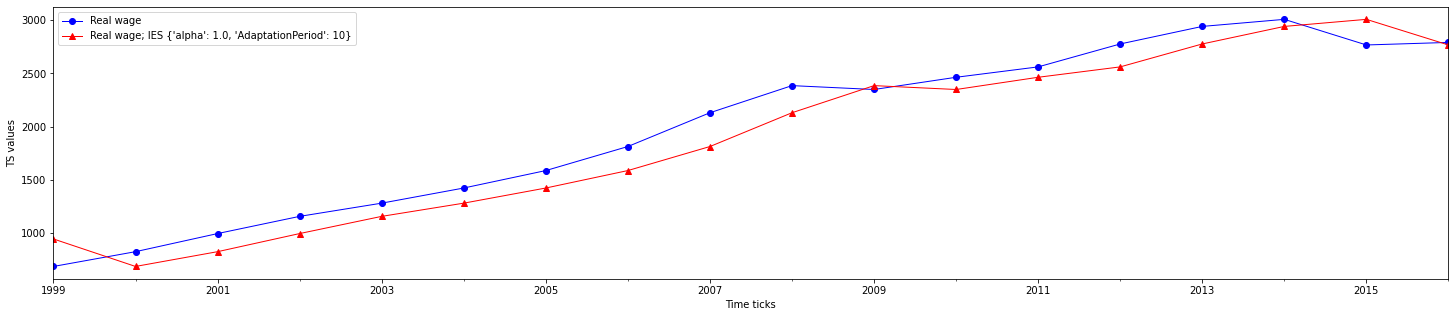

**Remember**
   - Empirical rules:

  if $\alpha^*\in(0,0.3)$ the series is stationary, ES works;

  if $\alpha^*\in(0.3,1)$ the series is non-stationary, we need a trend model.



```
# This is formatted as code
```

# Prophet vs Exponential Smoothing

In [ ]:
# use only for the first run:
# !pip install sktime 
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

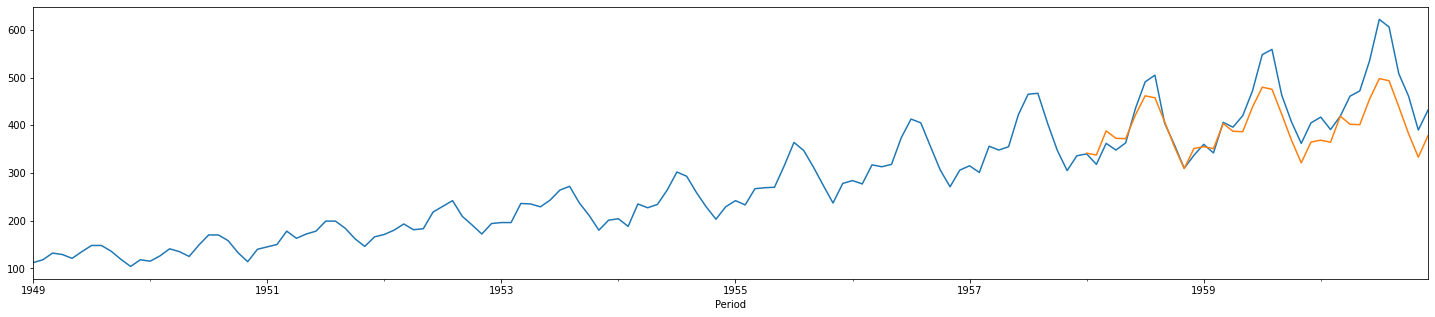

In [ ]:
y.plot(figsize = (25,5))
y_pred.plot()

In [ ]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)


0.08661467760556908

In [ ]:
`from copy import deepcopy
quality_wholehist1 = deepcopy(quality_wholehist)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-11,3.505913,-0.035253,6.703277,3.505913,3.505913,-0.116928,-0.116928,-0.116928,-0.522247,-0.522247,-0.522247,0.405319,0.405319,0.405319,0.0,0.0,0.0,3.388986
1,2005-01-12,3.507174,-0.153726,6.849929,3.507174,3.507174,-0.121681,-0.121681,-0.121681,-0.381678,-0.381678,-0.381678,0.259996,0.259996,0.259996,0.0,0.0,0.0,3.385493
2,2005-01-13,3.508435,-0.396955,6.652350,3.508435,3.508435,-0.361023,-0.361023,-0.361023,-0.480060,-0.480060,-0.480060,0.119038,0.119038,0.119038,0.0,0.0,0.0,3.147412
3,2005-01-14,3.509695,-0.364555,6.901167,3.509695,3.509695,-0.232490,-0.232490,-0.232490,-0.217451,-0.217451,-0.217451,-0.015039,-0.015039,-0.015039,0.0,0.0,0.0,3.277206
4,2005-01-15,3.510956,1.555010,8.372556,3.510956,3.510956,1.520842,1.520842,1.520842,1.660781,1.660781,1.660781,-0.139938,-0.139938,-0.139938,0.0,0.0,0.0,5.031798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,2009-06-06,2.678578,-0.045896,6.754216,2.434366,2.893253,0.765112,0.765112,0.765112,1.660781,1.660781,1.660781,-0.895669,-0.895669,-0.895669,0.0,0.0,0.0,3.443690
1608,2009-06-07,2.677475,-1.361376,5.327816,2.432188,2.893020,-0.612733,-0.612733,-0.612733,0.319752,0.319752,0.319752,-0.932485,-0.932485,-0.932485,0.0,0.0,0.0,2.064741
1609,2009-06-08,2.676372,-1.961113,5.076273,2.430010,2.892788,-1.336092,-1.336092,-1.336092,-0.379097,-0.379097,-0.379097,-0.956995,-0.956995,-0.956995,0.0,0.0,0.0,1.340280
1610,2009-06-09,2.675269,-2.124153,4.246476,2.428147,2.892555,-1.490777,-1.490777,-1.490777,-0.522247,-0.522247,-0.522247,-0.968530,-0.968530,-0.968530,0.0,0.0,0.0,1.184491


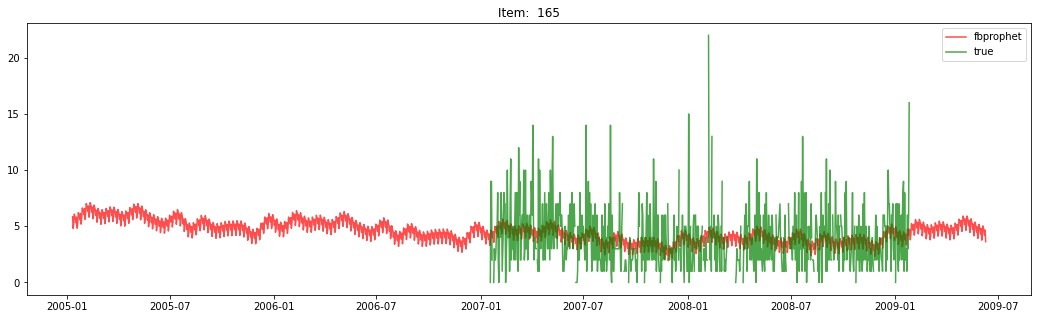

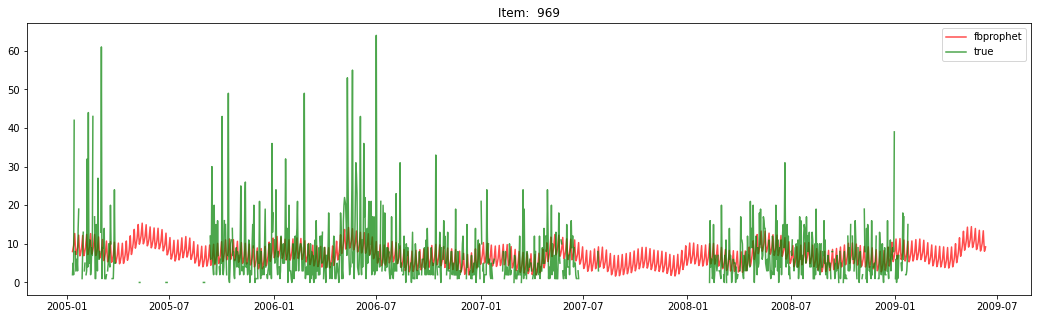

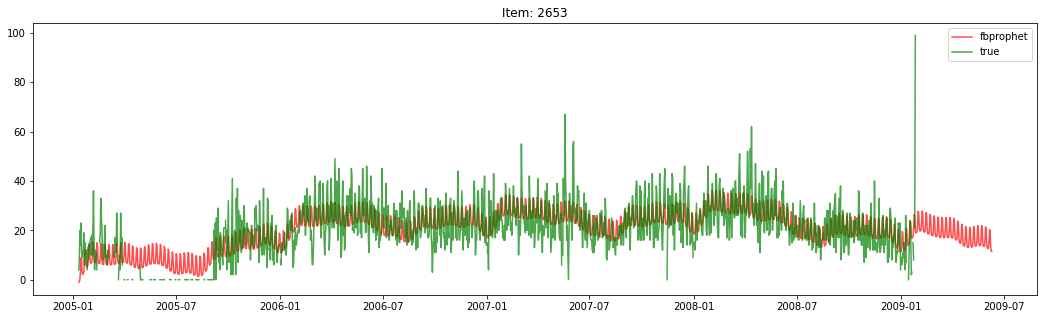

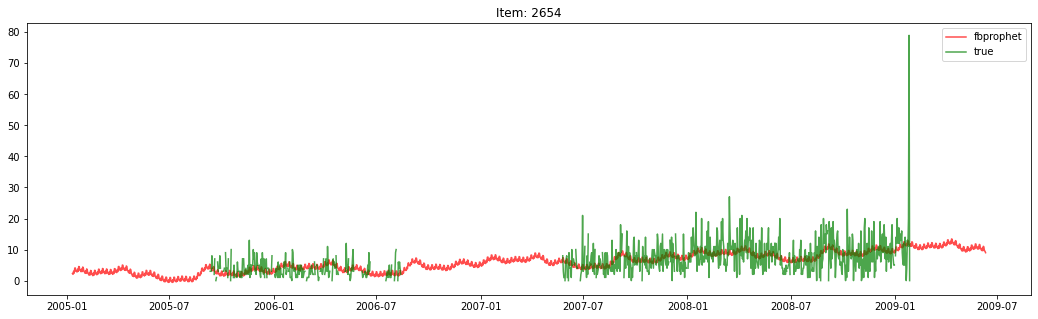

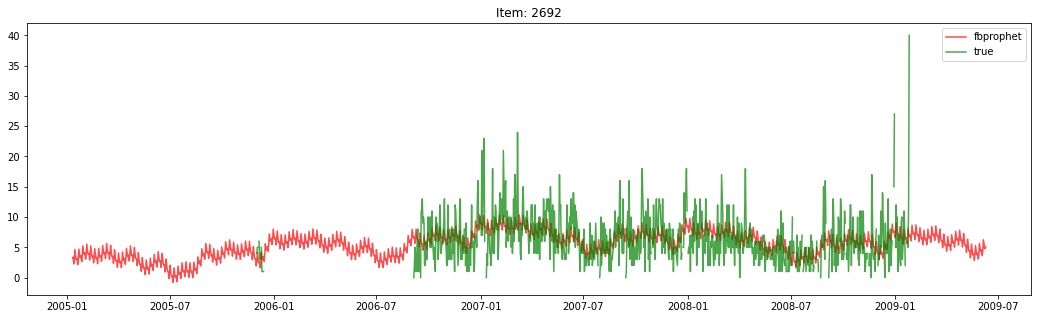

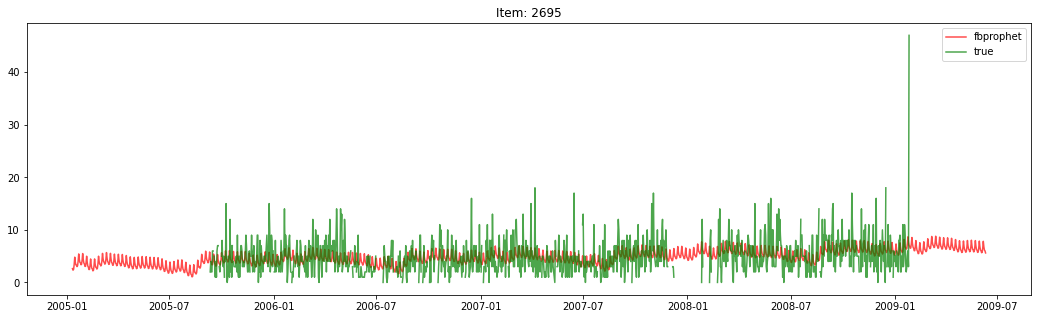

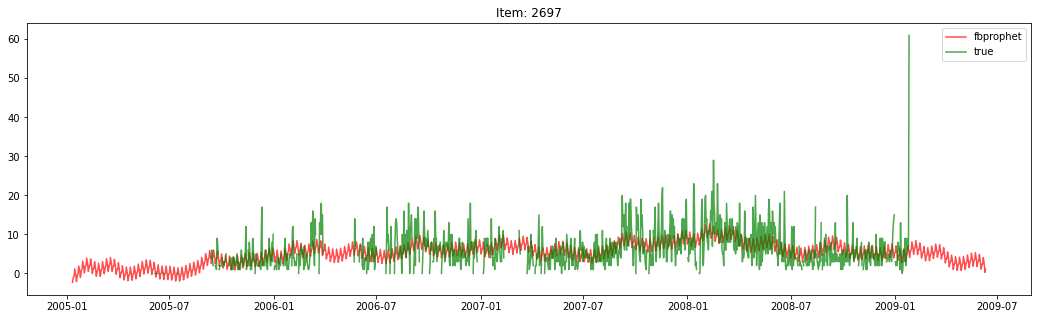

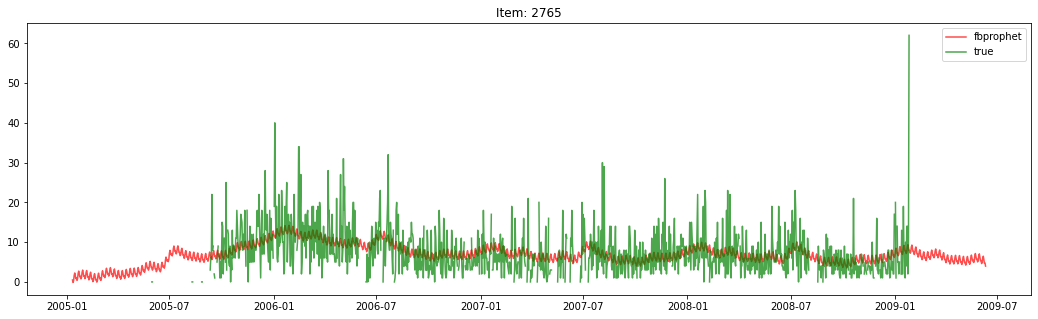

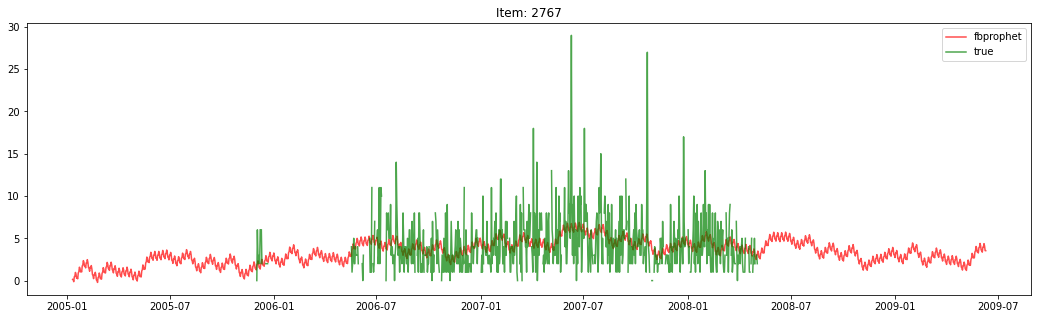

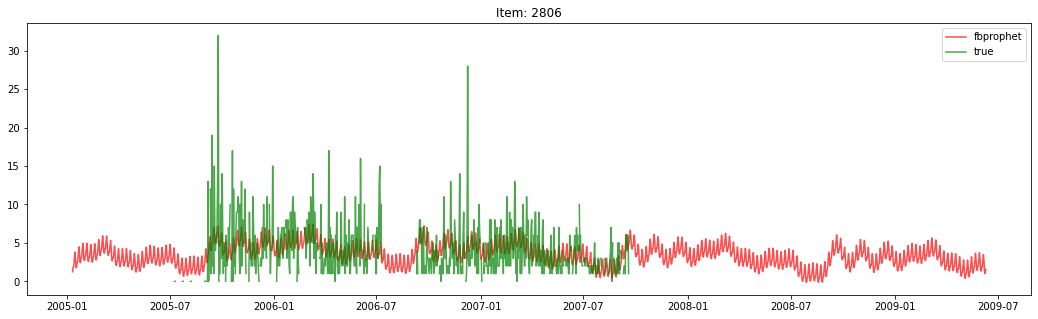

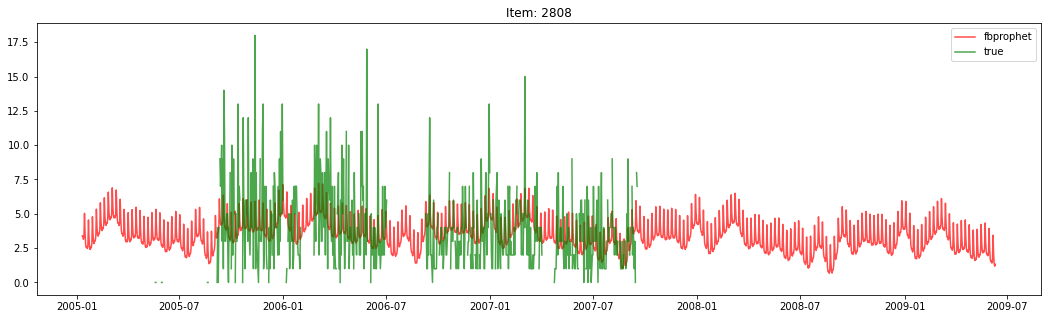

In [ ]:
from fbprophet import Prophet

#suppressing the info logs
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts[col])
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_wholehist1.loc[col, 'FBP'],_ = qualityMAPE(df['y'], forecast.set_index('ds').loc[ts.index]['yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

Text(0, 0.5, 'MAPE')

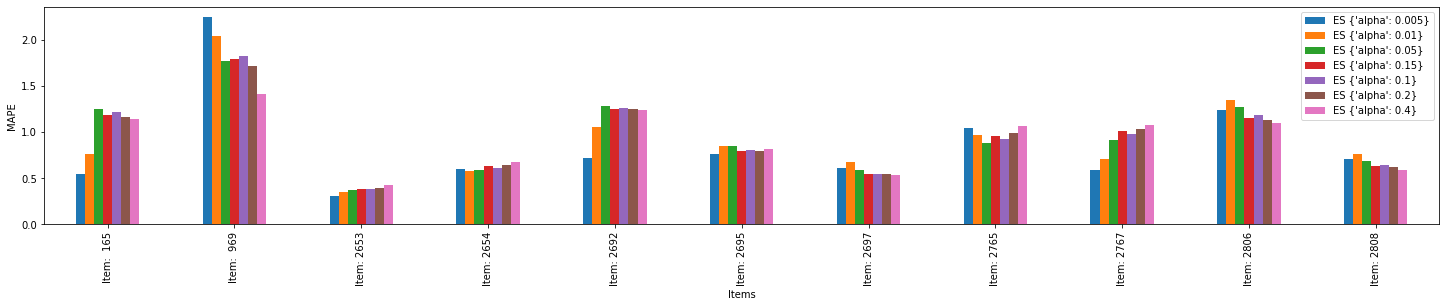

In [ ]:
# generate forecast with SES for h = 100 next days after fs_start_dt
fs_start_dt = '07-01-2007'
h = 100

ALPHA = [0.4, 0.2, .15, 0.1, 0.05, 0.01, 0.005]
ESparams_array = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=h, ts=ts[:fs_start_dt], alg_name =  'SimpleExponentialSmoothing', alg_title='ES' ,params_array = ESparams_array)


quality_100days = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within first 100 steps after fs_start_dt
for model in quality_100days.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(pd.to_datetime(fs_start_dt), pd.to_datetime(fs_start_dt)+timedelta(h) )
        quality_100days[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

# ax = quality_100days[sorted(quality_100days.columns)].plot.bar(figsize = (25,4))
# ax.set_xlabel("Items")
# ax.set_ylabel("MAPE")

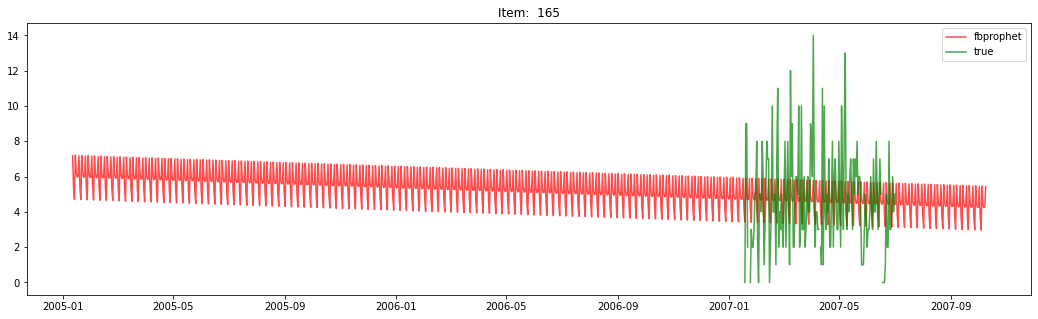

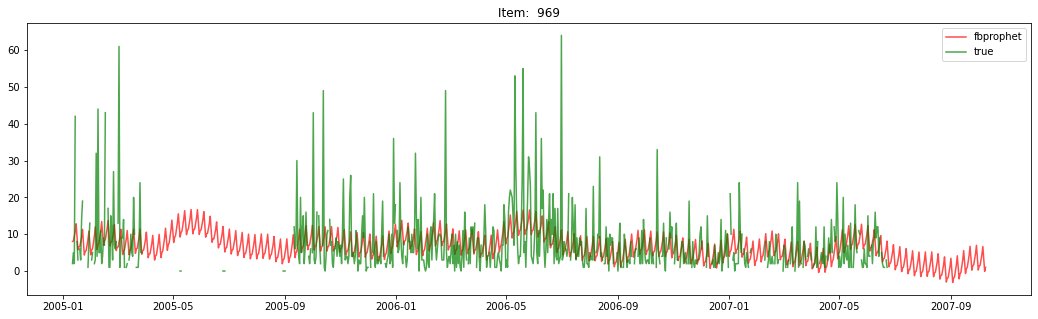

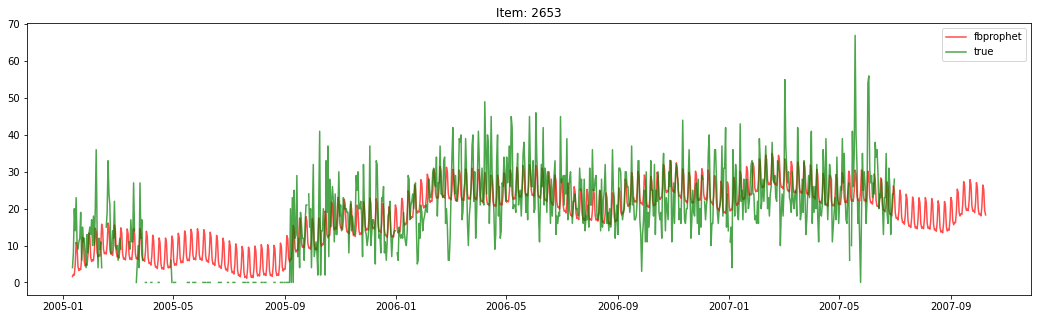

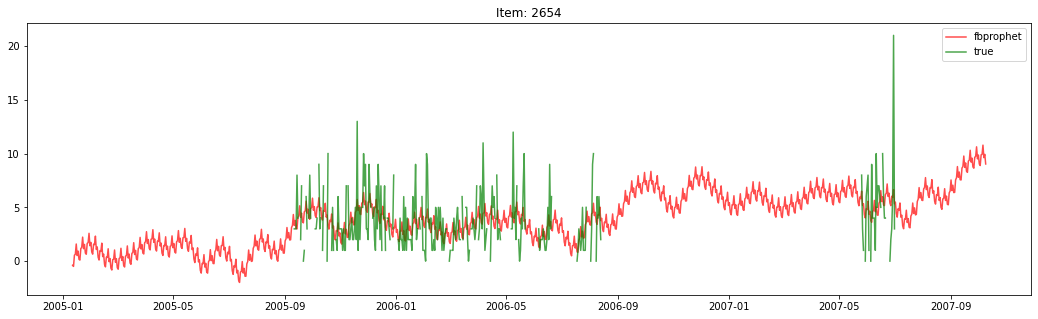

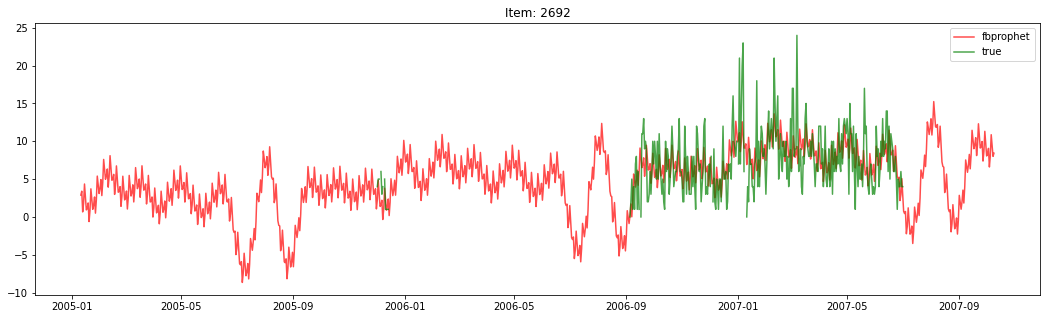

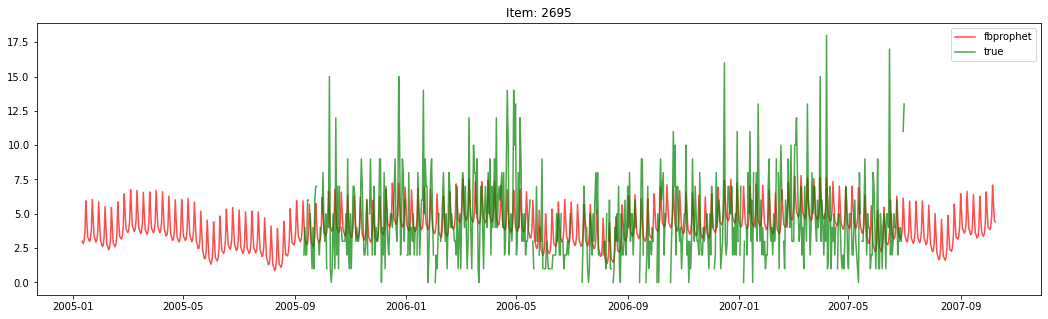

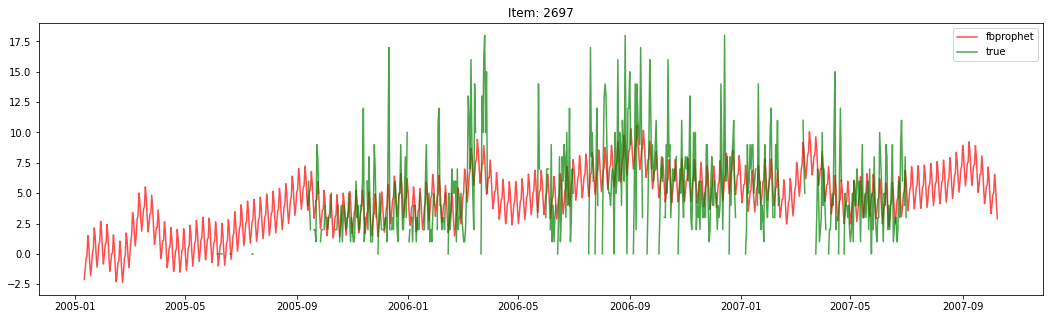

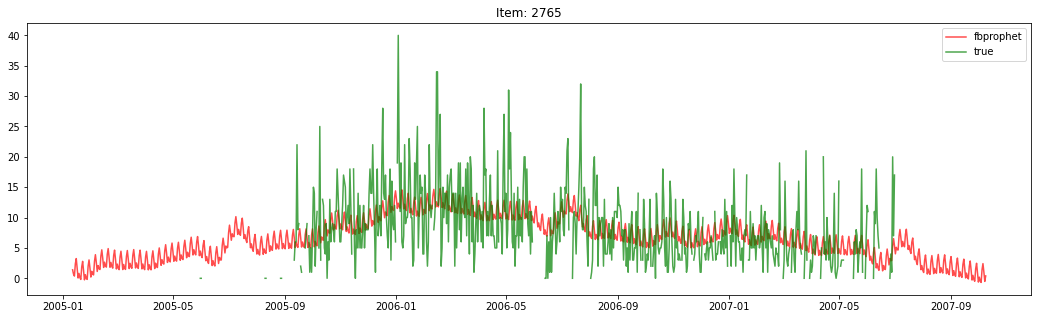

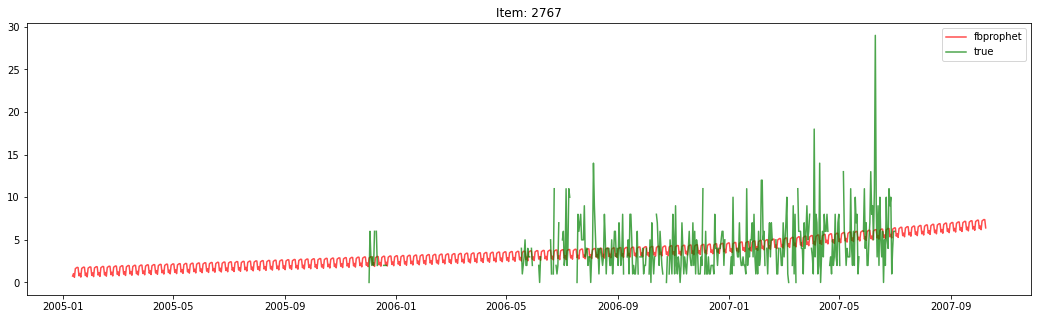

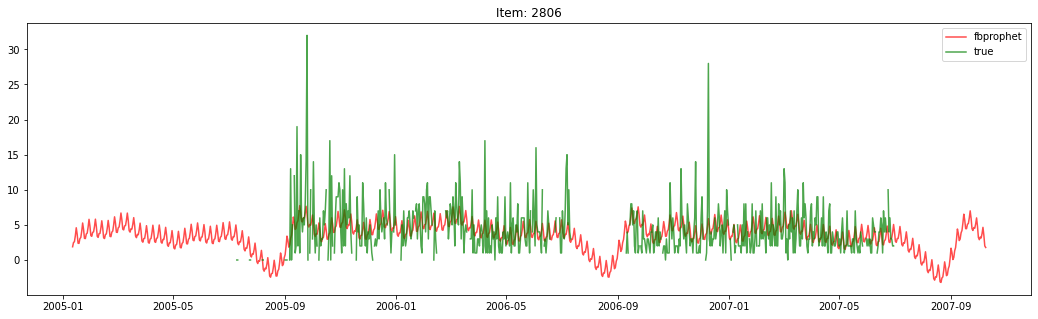

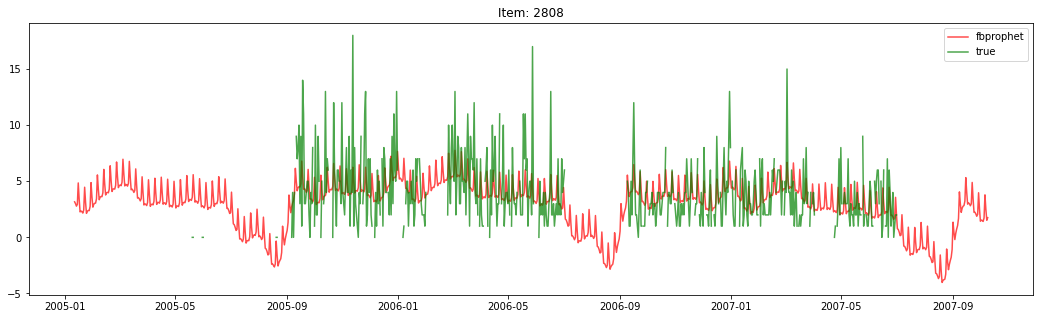

In [ ]:
# generate forecast since fs_start_dt
for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts.loc[:fs_start_dt, col])
    df['ds'] = ts[:fs_start_dt].index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_100days.loc[col, 'FBP'],_ = qualityMAPE(ts.loc[fs_start_dt:, col], forecast.set_index('ds').loc[fs_start_dt:, 'yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

Text(0, 0.5, 'MAPE')

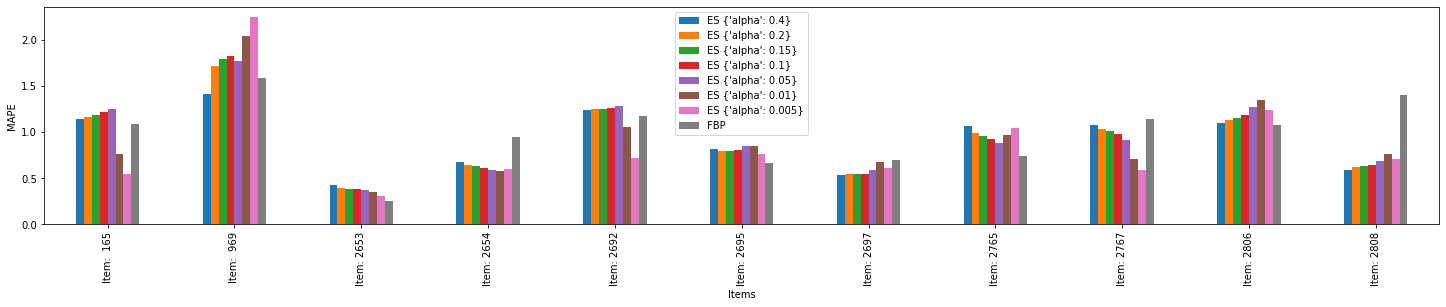

In [ ]:
ax = quality_100days.plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

# Materials
* Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.